In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
import scipy.signal as sg
import cmath as cm
import alphashape as ap
from scipy import interpolate
from scipy import integrate
import math
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from scipy.interpolate import interp1d, CubicSpline
from matplotlib.colors import Normalize, LogNorm,PowerNorm
from concurrent.futures import ProcessPoolExecutor
from scipy.spatial import ConvexHull, Delaunay
from shapely.geometry import Point
from scipy.optimize import fsolve
from sympy import Derivative
from tqdm import tqdm
import time
from scipy.interpolate import griddata
import pandas as pd

In [2]:
def BHZmodel(m,t,kx,ky,eta0,eta1,eta2):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    gamma0 = np.kron(np.eye(2),sigmaz)
    gamma1 = np.kron(np.eye(2),sigmay)
    gamma2 = np.kron(sigmaz,sigmax)
    
    h0 = m+t*np.cos(kx)+t*np.cos(ky)+1j*eta0
    h1 = t*np.sin(ky)+1j*eta1
    h2 = t*np.sin(kx)+1j*eta2
    
    H = h0*gamma0+h1*gamma1+h2*gamma2
    return H

def LTSTBHZ(m,t,kx,ky,eta0,eta1,eta2,Time,rho0):
    H = BHZmodel(m,t,kx,ky,eta0,eta1,eta2)
    HL = H.T.conjugate()
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    gamma0 = np.kron(np.eye(2),sigmaz)
    gamma1 = np.kron(np.eye(2),sigmay)
    gamma2 = np.kron(sigmaz,sigmax)

    U = expm(-1j*H*Time[-1]) 
    UL= expm(1j*HL*Time[-1])

    Spin0= np.trace(U@rho0@UL@gamma0)/np.trace(U@rho0@UL)
    Spin1= np.trace(U@rho0@UL@gamma1)/np.trace((U@rho0@UL))
    Spin2= np.trace(U@rho0@UL@gamma2)/np.trace((U@rho0@UL))
    
    return Spin0,Spin1,Spin2

def deformedLTSTBHZ(m, t, kx, ky, eta0, eta1, eta2, Time, rho0, delta, N=2):
    def compute_spin(kx, ky):
        h0 = m + t*np.cos(kx) + t*np.cos(ky) + 1j*eta0
        h1 = t*np.sin(ky) + 1j*eta1
        h2 = t*np.sin(kx) + 1j*eta2
        En = np.sqrt(h0**2 + h1**2 + h2**2)

        H = BHZmodel(m, t, kx, ky, eta0, eta1, eta2)
        HL = H.T.conj()

        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        sigmaz = np.array([[1, 0], [0, -1]])

        gamma0 = np.kron(np.eye(2), sigmaz)
        gamma1 = np.kron(np.eye(2), sigmay)
        gamma2 = np.kron(sigmaz, sigmax)

        U = expm(-1j * H * Time[-1])
        UL = expm(1j * HL * Time[-1])

        Spin0 = np.trace(U @ rho0 @ UL @ gamma0) / np.trace(U @ rho0 @ UL)
        Spin1 = np.trace(U @ rho0 @ UL @ gamma1) / np.trace(U @ rho0 @ UL)
        Spin2 = np.trace(U @ rho0 @ UL @ gamma2) / np.trace(U @ rho0 @ UL)

        return En, np.array([Spin0, Spin1, Spin2])

    En, Spin = compute_spin(kx, ky)

    if np.abs(En.imag) >= 5e-2:
        return tuple(-Spin if En.imag < 0 else Spin)
    else:
        # 邻域均值插值替代
        spin_vals = []
        for dx in range(-N, N+1):
            for dy in range(-N, N+1):
                if dx == 0 and dy == 0:
                    continue
                nkx = kx + dx * delta
                nky = ky + dy * delta
                En_n, Spin_n = compute_spin(nkx, nky)
                #if np.abs(En_n.imag) >= 1e-3:
                    # 根据 En_n.imag 正负号决定符号
                if En_n.imag < 0:
                    Spin_n = -Spin_n
                spin_vals.append(Spin_n)

        Spin_interp = np.mean(spin_vals, axis=0)
        return tuple(Spin_interp)

    

def QmatrixBHZ(m,t,kx,ky,eta0,eta1,eta2):
    H =  BHZmodel(m,t,kx,ky,eta0,eta1,eta2)
    HL = H.T.conjugate()

    h0 = m+t*np.cos(kx)+t*np.cos(ky)+1j*eta0
    h1 = t*np.sin(ky)+1j*eta1
    h2 = t*np.sin(kx)+1j*eta2

    En = np.sqrt(h0**2+h1**2+h2**2)

    Q = 1/2*(H/En+HL/En.conjugate())
    Spin0 = 1/2* (h0/En + (h0/En).conjugate()) #np.trace(Q@gamma1)
    Spin1 =  1/2* (h1/En + (h1/En).conjugate()) #np.trace(Q@gamma2)
    Spin2 =  1/2* (h2/En + (h2/En).conjugate()) #np.trace(Q@gamma3)
    
    SpinN = np.sqrt(Spin0**2+Spin1**2+Spin2**2)
    return Spin0/SpinN,Spin1/SpinN,Spin2/SpinN



In [3]:
m=1
t=1
eta0,eta1,eta2=0.2,0.2,0.2
Time = np.linspace(0,500,100)
kx = np.linspace(-np.pi,np.pi,101)
ky = np.linspace(-np.pi,np.pi,101)
Spin0Q = np.zeros((len(kx),len(ky)))
Spin1Q = np.zeros((len(kx),len(ky)))
Spin2Q = np.zeros((len(kx),len(ky)))

Spin0L = np.zeros((len(kx),len(ky)))
Spin1L = np.zeros((len(kx),len(ky)))
Spin2L = np.zeros((len(kx),len(ky)))

sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])
dk = kx[1]-kx[0]
Cs = np.kron(sigmay,sigmax)
rho0 = 1/2*(np.eye(4)-Cs)
for i in tqdm(np.arange(len(kx)), desc="Calculating", unit="step"):
    for j in np.arange(len(ky)):
        Spin0L[i][j],Spin1L[i][j],Spin2L[i][j] = deformedLTSTBHZ(m,t,kx[i],ky[j],eta0,eta1,eta2,Time,rho0,dk,3)
        Spin0Q[i][j],Spin1Q[i][j],Spin2Q[i][j] = QmatrixBHZ(m,t,kx[i],ky[j],eta0,eta1,eta2)

Calculating:   0%|          | 0/101 [00:00<?, ?step/s]C:\Users\lin\AppData\Local\Temp\ipykernel_8140\986750673.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Spin0L[i][j],Spin1L[i][j],Spin2L[i][j] = deformedLTSTBHZ(m,t,kx[i],ky[j],eta0,eta1,eta2,Time,rho0,dk,3)
C:\Users\lin\AppData\Local\Temp\ipykernel_8140\986750673.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  Spin0Q[i][j],Spin1Q[i][j],Spin2Q[i][j] = QmatrixBHZ(m,t,kx[i],ky[j],eta0,eta1,eta2)
Calculating: 100%|██████████| 101/101 [00:51<00:00,  1.96step/s]


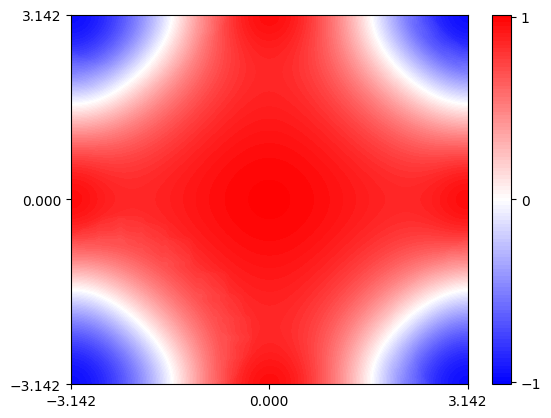

In [12]:
Qx,Qy = np.meshgrid(kx,ky,indexing='ij')
plt.figure()
plt.contourf(Qx,Qy,Spin0L,cmap='bwr',levels=np.linspace(-1.01,1.01,100))
plt.colorbar().set_ticks([-1, 0, 1])  # 设置 colorbar 的刻度
plt.xticks([-np.pi, 0, np.pi])
plt.yticks([-np.pi, 0, np.pi])
#plt.savefig('sigma0.svg')
plt.show()

In [157]:
data = np.column_stack((Qx.ravel(), Qy.ravel(), Spin0L.ravel()))
df = pd.DataFrame(data, columns=["kx", "ky", "gamma0"])
df.to_csv("Fig_4(a).csv", index=False)

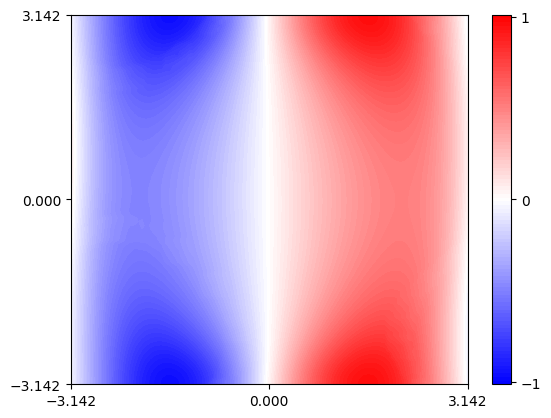

In [11]:
Qx,Qy = np.meshgrid(kx,ky,indexing='ij')
plt.figure()
plt.contourf(Qx,Qy,Spin2L,cmap='bwr',levels=np.linspace(-1.01,1.01,100))
plt.colorbar().set_ticks([-1, 0, 1])  # 设置 colorbar 的刻度
plt.xticks([-np.pi, 0, np.pi])
plt.yticks([-np.pi, 0, np.pi])
#plt.savefig('sigma1.svg')
plt.show()

In [158]:
data = np.column_stack((Qx.ravel(), Qy.ravel(), Spin2L.ravel()))
df = pd.DataFrame(data, columns=["kx", "ky", "gamma2"])
df.to_csv("Fig_4(b).csv", index=False)

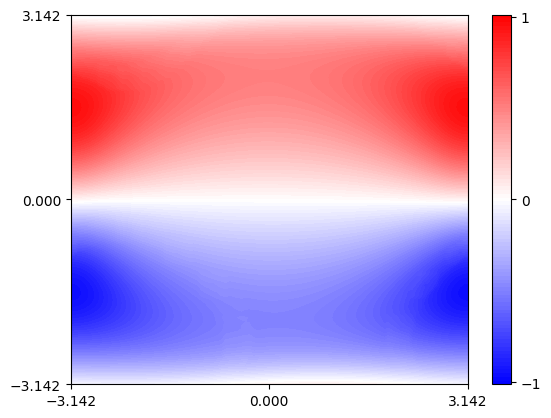

In [6]:
Qx,Qy = np.meshgrid(kx,ky,indexing='ij')
plt.figure()
plt.contourf(Qx,Qy,Spin1L,cmap='bwr',levels=np.linspace(-1.01,1.01,100))
plt.colorbar().set_ticks([-1, 0, 1])  # 设置 colorbar 的刻度
plt.xticks([-np.pi, 0, np.pi])
plt.yticks([-np.pi, 0, np.pi])
#plt.savefig('sigma2.svg')
plt.show()

In [159]:
data = np.column_stack((Qx.ravel(), Qy.ravel(), Spin1L.ravel()))
df = pd.DataFrame(data, columns=["kx", "ky", "gamma1"])
df.to_csv("Fig_4(c).csv", index=False)